In [1]:
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

# the dataset for the demo
from sklearn.datasets import load_boston

from sklearn.model_selection import train_test_split

# for discretization
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisers import EqualWidthDiscretiser

In [2]:
# load the the Boston House price data from Scikit-learn
boston_dataset = load_boston()

# create a dataframe with the independent variables
data = pd.DataFrame(boston_dataset.data,
                    columns=boston_dataset.feature_names)

# add the target
data['MEDV'] = boston_dataset.target

data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

## Equal-width discretization with pandas

First we need to determine the interval edges or limits.

In [4]:
# let's capture the value range of the variable LSTAT

lstat_range = X_train['LSTAT'].max() - X_train['LSTAT'].min()

lstat_range

35.25

In [5]:
# let's divide the range into 10 equal-width bins

lstat_range / 10

3.525

In [6]:
# now let's capture the lower and upper boundaries

min_value = int(np.floor( X_train['LSTAT'].min()))
max_value = int(np.ceil( X_train['LSTAT'].max()))

# let's round the bin width
inter_width = int(lstat_range / 10)

min_value, max_value, inter_width

(1, 37, 3)

In [7]:
# let's capture the interval limits, so we can pass them to the pandas cut()
# function to generate the bins

intervals = [i for i in range(min_value, max_value+inter_width, inter_width)]

intervals

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37]

In [8]:
# discretise LSTAT

X_train['lstat_disc'] = pd.cut(x=X_train['LSTAT'],
                               bins=intervals,
                               include_lowest=True)


print(X_train[['LSTAT', 'lstat_disc']].head(10))

     LSTAT    lstat_disc
141  34.41  (34.0, 37.0]
272   7.73   (7.0, 10.0]
135  16.96  (16.0, 19.0]
298   4.97    (4.0, 7.0]
122  17.93  (16.0, 19.0]
22   18.72  (16.0, 19.0]
68   13.09  (13.0, 16.0]
20   21.02  (19.0, 22.0]
437  26.45  (25.0, 28.0]
14   10.26  (10.0, 13.0]


In [9]:
# let's check the number of observations per bin

X_train['lstat_disc'].value_counts()

(4.0, 7.0]      67
(7.0, 10.0]     63
(10.0, 13.0]    49
(16.0, 19.0]    45
(13.0, 16.0]    44
(0.999, 4.0]    28
(19.0, 22.0]    21
(22.0, 25.0]    17
(28.0, 31.0]     9
(25.0, 28.0]     7
(34.0, 37.0]     4
(31.0, 34.0]     0
Name: lstat_disc, dtype: int64

Text(0, 0.5, 'Number of observations per bin')

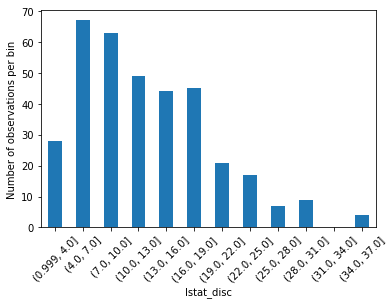

In [10]:
# let's plot the number of observations per bin

X_train.groupby('lstat_disc')['LSTAT'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

In [11]:
# let's discretise the variables in the test set

X_test['lstat_disc'] = pd.cut(x=X_test['LSTAT'],
                              bins=intervals,
                              include_lowest=True)

X_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,lstat_disc
329,0.06724,0.0,3.24,0.0,0.460,6.333,17.2,5.2146,4.0,430.0,16.9,375.21,7.34,"(7.0, 10.0]"
371,9.23230,0.0,18.10,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,"(7.0, 10.0]"
219,0.11425,0.0,13.89,1.0,0.550,6.373,92.4,3.3633,5.0,276.0,16.4,393.74,10.50,"(10.0, 13.0]"
403,24.80170,0.0,18.10,0.0,0.693,5.349,96.0,1.7028,24.0,666.0,20.2,396.90,19.77,"(19.0, 22.0]"
78,0.05646,0.0,12.83,0.0,0.437,6.232,53.7,5.0141,5.0,398.0,18.7,386.40,12.34,"(10.0, 13.0]"


Text(0, 0.5, 'Number of observations per bin')

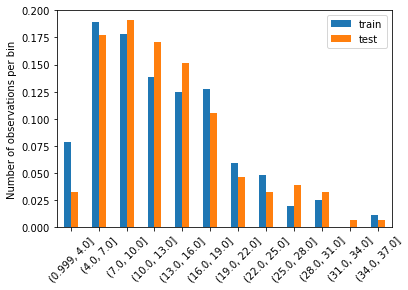

In [12]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

# determine proportion of observations in each bin
t1 = X_train['lstat_disc'].value_counts() / len(X_train)
t2 = X_test['lstat_disc'].value_counts() / len(X_test)

# concatenate aggregated views
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']

# plot
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

## Equal-width discretization with Feature-engine

In [13]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

In [14]:
# with feature engine we can automate the process for many variables
# in one line of code

disc = EqualWidthDiscretiser(bins=10, variables = ['LSTAT', 'DIS', 'RM'])

disc.fit(X_train)

EqualWidthDiscretiser(bins=10, return_object=False,
                      variables=['LSTAT', 'DIS', 'RM'])

In [15]:
# the limits of the intervals are stored in the binner_dict_

disc.binner_dict_

{'LSTAT': [-inf,
  5.255,
  8.78,
  12.305,
  15.83,
  19.355,
  22.88,
  26.405,
  29.93,
  33.455,
  inf],
 'DIS': [-inf,
  2.26943,
  3.36466,
  4.459890000000001,
  5.5551200000000005,
  6.65035,
  7.745580000000001,
  8.840810000000001,
  9.936040000000002,
  11.031270000000003,
  inf],
 'RM': [-inf,
  4.0828999999999995,
  4.6048,
  5.1267,
  5.6486,
  6.1705,
  6.692399999999999,
  7.2143,
  7.736199999999999,
  8.258099999999999,
  inf]}

In [16]:
# transform train and test sets

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

Text(0, 0.5, 'Number of observations per bin')

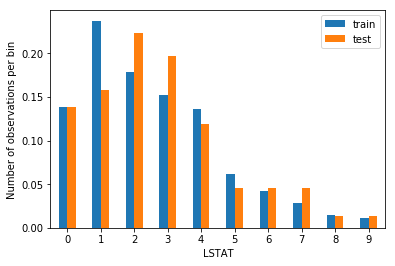

In [17]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# LSTAT
# calculate proportion of observations per interval
t1 = train_t.groupby(['LSTAT'])['LSTAT'].count() / len(train_t)
t2 = test_t.groupby(['LSTAT'])['LSTAT'].count() / len(test_t)

# concatenate aggregated views
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']

# plot
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

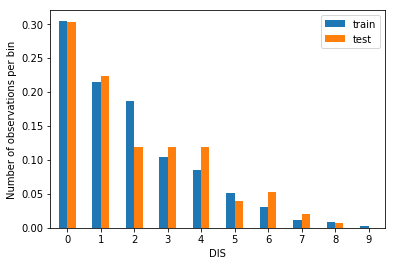

In [18]:
# DIS

t1 = train_t.groupby(['DIS'])['DIS'].count() / len(train_t)
t2 = test_t.groupby(['DIS'])['DIS'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

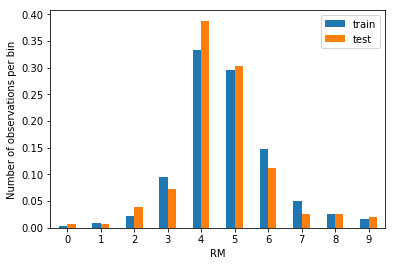

In [19]:
# RM

t1 = train_t.groupby(['RM'])['RM'].count() / len(train_t)
t2 = test_t.groupby(['RM'])['RM'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

## Equal-width discretization with Scikit-Learn

In [20]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

In [21]:
# let's set up an equal-width discretizer into 10 intervals

disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# let's fit the discretizer so it learns the interval limits
disc.fit(X_train[['LSTAT', 'DIS', 'RM']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [22]:
# the interval limits are stored in the bin_edges_attribute

disc.bin_edges_

array([array([ 1.73 ,  5.255,  8.78 , 12.305, 15.83 , 19.355, 22.88 , 26.405,
       29.93 , 33.455, 36.98 ]),
       array([ 1.1742 ,  2.26943,  3.36466,  4.45989,  5.55512,  6.65035,
        7.74558,  8.84081,  9.93604, 11.03127, 12.1265 ]),
       array([3.561 , 4.0829, 4.6048, 5.1267, 5.6486, 6.1705, 6.6924, 7.2143,
       7.7362, 8.2581, 8.78  ])], dtype=object)

In [23]:
# let's transform the train set, remember that Sklearn returns Numpy arrays
train_t = disc.transform(X_train[['LSTAT', 'DIS', 'RM']])

# transform array to dataframe
train_t = pd.DataFrame(train_t, columns = ['LSTAT', 'DIS', 'RM'])

train_t.head()

,LSTAT,DIS,RM
0,9.0,0.0,2.0
1,1.0,2.0,5.0
2,4.0,0.0,5.0
3,0.0,6.0,5.0
4,4.0,0.0,4.0


In [24]:
# same thing for test set

test_t = disc.transform(X_test[['LSTAT', 'DIS', 'RM']])

test_t = pd.DataFrame(test_t, columns = ['LSTAT', 'DIS', 'RM'])

Text(0, 0.5, 'Number of observations per bin')

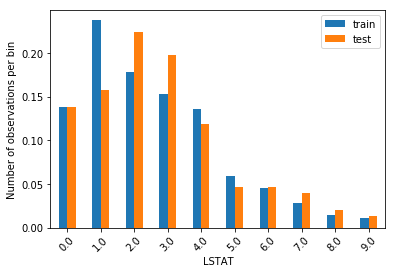

In [25]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# LSTAT

t1 = train_t.groupby(['LSTAT'])['LSTAT'].count() / len(train_t)
t2 = test_t.groupby(['LSTAT'])['LSTAT'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

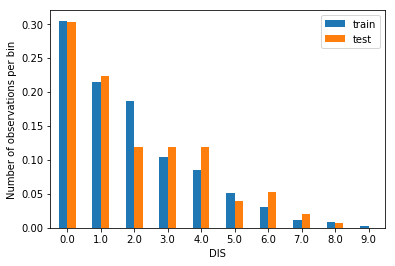

In [26]:
# DIS

t1 = train_t.groupby(['DIS'])['DIS'].count() / len(train_t)
t2 = test_t.groupby(['DIS'])['DIS'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

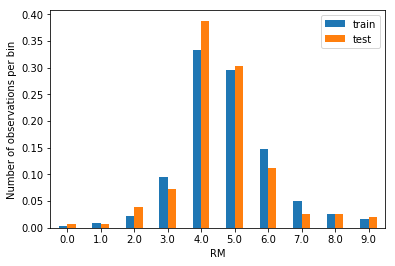

In [27]:
# RM

t1 = train_t.groupby(['RM'])['RM'].count() / len(train_t)
t2 = test_t.groupby(['RM'])['RM'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')